**<h1 align="center">TALLER 7 DATA SCIENCE</h1>**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn # Paquete base de ML

from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

%matplotlib inline

## Recapitulando clustering
- Crear una matriz de distancia usando criterio de enlace
    - ```method```: como calcular la proximidad de los clusters
    - ```metric```: metrica de distancia
    - ```optimal_ordering```: Orden de los puntos 
- Tipos de method
    - single: basado en los 2 objetos mas cercanos
    - complete: basado en los dos objetos mas lejanos 
    - average: basado en la media aritmetica de todos los objetos 
    - centroids: basado en la media geometrica de todos los objetos 
    - median: basado en la median de todos los objetos 
    - ward: basado en la suma de cuadrado 

# Agrupación en el conjunto de datos del vehículo

Imagine que un fabricante de automóviles ha desarrollado prototipos para un vehículo nuevo. Antes de introducir el nuevo modelo en su gama, el fabricante quiere determinar qué vehículos existentes en el mercado se parecen más a los prototipos, es decir, cómo se pueden agrupar los vehículos, qué grupo es el más similar al modelo y, por tanto, qué modelos. estarán compitiendo contra ellos.

Nuestro objetivo aquí es utilizar métodos de agrupamiento para encontrar los grupos de vehículos más distintivos. Resumirá los vehículos existentes y ayudará a la fabricación a tomar decisiones sobre nuevos modelos de forma sencilla.

### Descargar datos
Para descargar los datos, usaremos **`!wget`**. Estos datos se encuentran alojado en una API: IBM Object Storage.
__ ¿Lo sabían? __ Cuando se trata de aprendizaje automático, es probable que trabaje con grandes conjuntos de datos. Como empresa, ¿dónde puede alojar sus datos? IBM ofrece una oportunidad única para las empresas, con 10 Tb de IBM Cloud Object Storage: [Pueden registrarse aqui](http://cocl.us/ML0101EN-IBM-Offer-CC)

In [2]:
!wget -O cars_clus.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cars_clus.csv

--2021-09-23 15:15:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cars_clus.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17774 (17K) [text/csv]
Saving to: ‘cars_clus.csv’

cars_clus.csv       100%[===================>]  17.36K  --.-KB/s    in 0s      

2021-09-23 15:15:28 (104 MB/s) - ‘cars_clus.csv’ saved [17774/17774]



# Leer los datos

In [3]:
filename = 'cars_clus.csv'
#Lectura
pdf = pd.read_csv(filename)
print ("Shape: ", pdf.shape)
pdf.head(5)

Shape:  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


Los features incluyen:
- price en thousands (price)
- engine size (engine_s)
- horsepower (horsepow)
- wheelbase (wheelbas)
- width (width)
- length (length)
- curb weight (curb_wgt)
- fuel capacity (fuel_cap) 
- fuel efficiency (mpg).

# Data cleaning

1. Observando el proceso que se observa en el codigo de abajo que pueden concluir de que se realizo ?

In [4]:
print ("Shape antes de cleaning: ", pdf.shape)
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True)
print ("Shape despues de cleaning: ", pdf.shape)
pdf.head(5)

Shape antes de cleaning:  (159, 16)
Shape despues de cleaning:  (117, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


**Respuesta**

R// En el codigo anteriormente plasmado se esta realizando una limpieza en el set de datos eliminando las filas que tienen valores nulos.

# Feature selection

2. Seleccionar las columnas ``engine_s,  horsepow, wheelbas, width, lenght, curb_wgt, fuel_cap y mpg`` y guardarlas en el dataset ``featureset``

In [5]:
featureset = pdf[['engine_s', 'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]
featureset.head(5)

,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg
0,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0
1,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0
2,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0
3,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0
4,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0


# Clustering usando SCIpy

3. En esta parte usamos el paquete Scipy para agrupar el conjunto de datos:
Primero, calculamos la matriz de distancias.

Convertir a una matriz de distancias el dataset ``feature_set`` utilizando la funcion ``featureset.values`` y guardar el resultado en ``feature_mtx``



In [15]:
#feature_mtx = featureset.values
#feature_mtx [0:5]

In [6]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

Con la matriz creada previamente ``feature_mtx`` correr el codigo de acontinuación (Esto consiste en encontrar una matriz de distancias entre individuos/automoviles). El resultado se guarda en una matriz D. 

**Nota** Si todo marcha en orden no deberia haber problemas con los siguientes dos segmentos de código

In [8]:
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
D

array([[0.        , 0.57777143, 0.75455727, ..., 0.28530295, 0.24917241,
        0.18879995],
       [0.57777143, 0.        , 0.22798938, ..., 0.36087756, 0.66346677,
        0.62201282],
       [0.75455727, 0.22798938, 0.        , ..., 0.51727787, 0.81786095,
        0.77930119],
       ...,
       [0.28530295, 0.36087756, 0.51727787, ..., 0.        , 0.41797928,
        0.35720492],
       [0.24917241, 0.66346677, 0.81786095, ..., 0.41797928, 0.        ,
        0.15212198],
       [0.18879995, 0.62201282, 0.77930119, ..., 0.35720492, 0.15212198,
        0.        ]])

En la agrupación aglomerativa, en cada iteración, el algoritmo debe actualizar la matriz de distancia para reflejar la distancia del grupo recién formado con los grupos restantes en el bosque.

Los siguientes métodos son compatibles con Scipy para calcular la distancia entre el grupo recién formado y cada uno:

     - single
     - complete
     - average
     - weighted
     - centroid
    
4. Utilizaremos __complete__ para nuestro caso, pero en una proxima oportunidad siéntanse libres de cambiarlo para ver cómo cambian los resultados. Calcular el objeto Z por medio de la siguiente estructura de código:

``import pylab``

``import scipy.cluster.hierarchy``

``z=scipy.cluster.hierachy.linkage(D,'complete')``



In [10]:
import pylab
import scipy.cluster.hierarchy
Z = scipy.cluster.hierarchy.linkage(D,'complete')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


Esencialmente, la agrupación jerárquica no requiere un número predeterminado de agrupaciones. Sin embargo, en algunas aplicaciones queremos una partición de clústeres disjuntos como en un clúster plano.

Entonces podemos usar una línea de corte:

In [11]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 1,  5,  5,  6,  5,  4,  6,  5,  5,  5,  5,  5,  4,  4,  5,  1,  6,
        5,  5,  5,  4,  2, 11,  6,  6,  5,  6,  5,  1,  6,  6, 10,  9,  8,
        9,  3,  5,  1,  7,  6,  5,  3,  5,  3,  8,  7,  9,  2,  6,  6,  5,
        4,  2,  1,  6,  5,  2,  7,  5,  5,  5,  4,  4,  3,  2,  6,  6,  5,
        7,  4,  7,  6,  6,  5,  3,  5,  5,  6,  5,  4,  4,  1,  6,  5,  5,
        5,  6,  4,  5,  4,  1,  6,  5,  6,  6,  5,  5,  5,  7,  7,  7,  2,
        2,  1,  2,  6,  5,  1,  1,  1,  7,  8,  1,  1,  6,  1,  1],
      dtype=int32)

In [12]:
# Determinar clusters
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 1,
       5, 3, 3, 3, 3, 3, 1, 3, 3, 4, 4, 4, 4, 2, 3, 1, 3, 3, 3, 2, 3, 2,
       4, 3, 4, 1, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 2, 1, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2,
       3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       3, 4, 1, 1, 3, 1, 1], dtype=int32)

# Dendrograma

5. Utilizar el objeto ``Z`` creado previamente en la funcion ``scipy.cluster.hierarchy.dendrogram`` para obtener el dendrograma para ello pueden utilizar de ayuda el siguiente código:
`

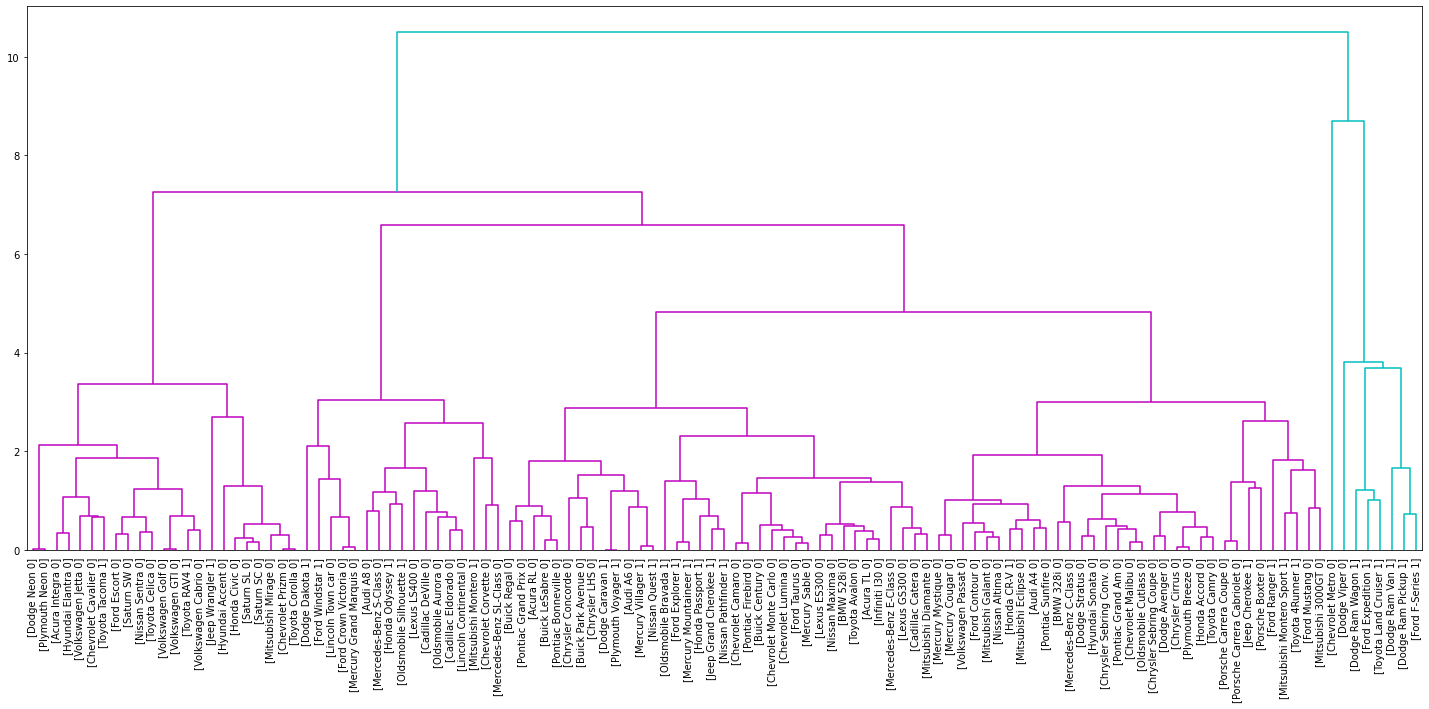

In [44]:
from scipy.cluster import hierarchy
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k', 'r'])
fig = pylab.figure(figsize=(25,10))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )
dn = hierarchy.dendrogram(Z,  leaf_label_func=llf, above_threshold_color='c', leaf_rotation=90, leaf_font_size =10, orientation='top')
plt.axhline(y=770, color='r', lw=1, linestyle='-')
plt.show()

In [45]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

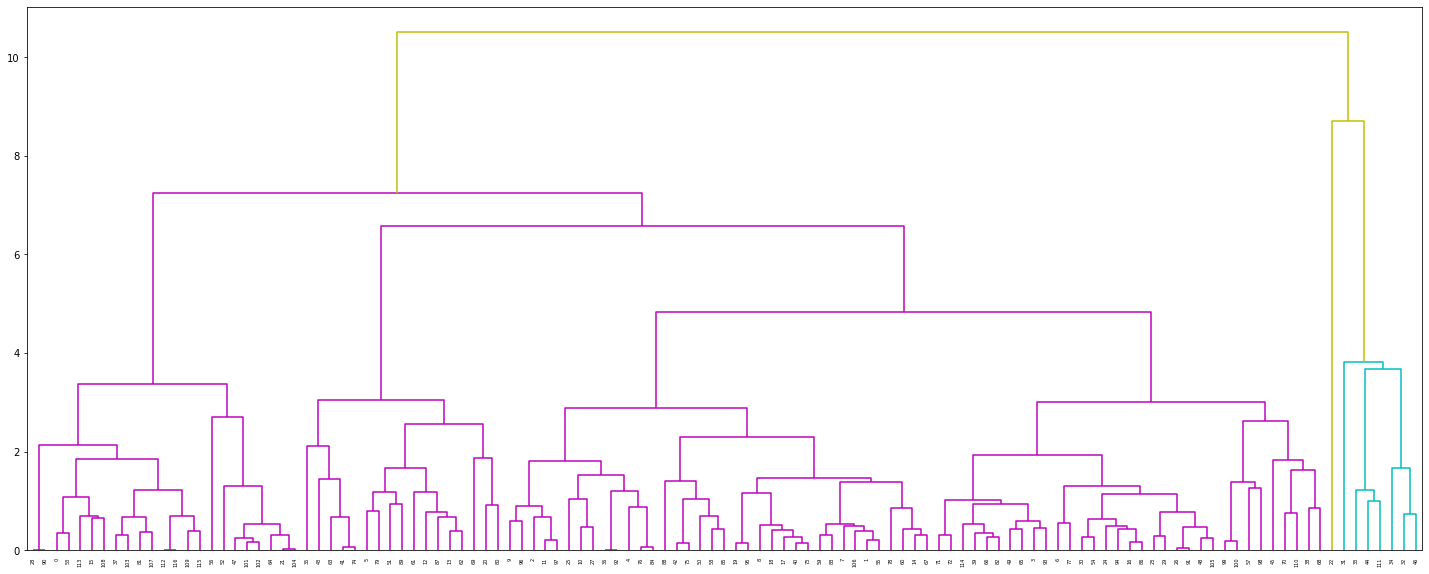

In [47]:
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig = pylab.figure(figsize=(25,10))
dn = hierarchy.dendrogram(Z, above_threshold_color='y', orientation = 'top')
plt.axhline(y=1000, color='r', linestyle='-' )

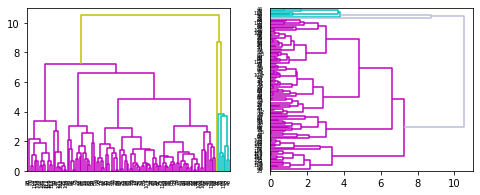

In [16]:
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                           above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

# Usando scikit learn

Ahora obtenemos la matriz de distancias usando scikit learn

In [17]:
from scipy.spatial import distance_matrix 

dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
print(dist_matrix)

[[0.         0.57777143 0.75455727 ... 0.28530295 0.24917241 0.18879995]
 [0.57777143 0.         0.22798938 ... 0.36087756 0.66346677 0.62201282]
 [0.75455727 0.22798938 0.         ... 0.51727787 0.81786095 0.77930119]
 ...
 [0.28530295 0.36087756 0.51727787 ... 0.         0.41797928 0.35720492]
 [0.24917241 0.66346677 0.81786095 ... 0.41797928 0.         0.15212198]
 [0.18879995 0.62201282 0.77930119 ... 0.35720492 0.15212198 0.        ]]


6. Utilizar el metodo ``AgglomerativeClustering`` visto en clase con ``n_clusters`` el número apropiado que consideren según en dendograma creado previamente y con propiedad ``linkage='complete'``. Guardar el modelo con el nombre``agglom``. Ajustar el modelo a los datos ``feature_mtx`` y obtener las predicciones con la funcion ``agglom.labels_``

In [25]:
from sklearn.cluster import AgglomerativeClustering 

agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 5, 1,
       4, 1, 1, 2, 1, 2, 1, 1, 1, 5, 0, 0, 0, 3, 2, 1, 2, 1, 2, 3, 2, 3,
       0, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 2, 3, 2, 3, 1, 2, 3, 5, 1, 1, 2, 3, 2, 1, 3,
       2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1])

7. Crear una columna en el dataset pdf que se llame ``cluster_`` con base en los labels obtenidos con ``agglom.labels_''

In [29]:
pdf['cluster_'] = agglom.labels_
pdf

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,1
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,2
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,2
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,1
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Volkswagen,Golf,9.761,11.425,0.0,14.90,2.0,115.0,98.9,68.3,163.3,2.767,14.5,26.0,2.278,0.0,1
113,Volkswagen,Jetta,83.721,13.240,0.0,16.70,2.0,115.0,98.9,68.3,172.3,2.853,14.5,26.0,4.427,0.0,1
114,Volkswagen,Passat,51.102,16.725,0.0,21.20,1.8,150.0,106.4,68.5,184.1,3.043,16.4,27.0,3.934,0.0,1
115,Volkswagen,Cabrio,9.569,16.575,0.0,19.99,2.0,115.0,97.4,66.7,160.4,3.079,13.7,26.0,2.259,0.0,1


8. Utilizar el siguiente codigo (Primero deben entenderlo) para crear una grafica de dispersion entre ``mpg`` y ``horsepow`` donde se proyecta como tercera variable el ``price``. Con base en esta grafica obtener una descripcion de cada cluster.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'mpg')

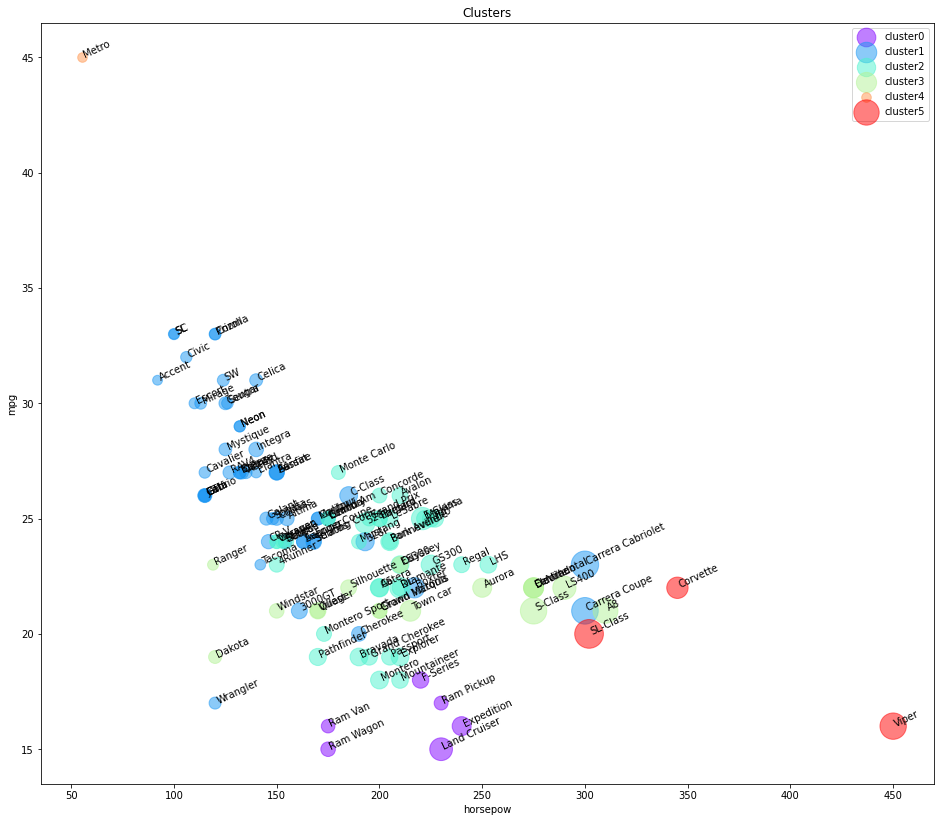

In [28]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Figura de tamaño 16 inches por 14 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

**Respuesta**




Como se puede ver, es una distribución de cada cluster utilizando una trama esparcida, pero no está muy claro dónde es el centroide de cada cluster.

- Cluster0: Autos de 175Hp - 240Hp aproximadamente con consumo de hasta 18 mpg aprox.

- Cluster1: Autos de 100Hp - 310Hp aproximadamente con consumo de hasta 34 mpg aprox.

- Cluster2: Autos de 160Hp - 260Hp aproximadamente con consumo de hasta 27 mpg aprox.

- Cluster3: Autos de 130Hp - 315Hp aproximadamente con consumo de hasta 23 mpg aprox.

- Cluster4: Segun se evidencia en la grafica plasmada anteriormente se puede evidenciar que solo hay 1 auto de 70HP aproximadamente con consumo de 45 mpg aproximadamente.

- Cluster5: Autos de 300HP - 450HP con consumo de hasta 23 mpg aproximadamente.

9. Obtener un conteo para cada cluster y analizar si las estructuras son balanceadas? Porque?

In [51]:
pdf.groupby(['cluster_'])['cluster_'].count()

cluster_
0     6
1    52
2    38
3    17
4     1
5     3
Name: cluster_, dtype: int64

***Respuesta***

Al realizar el conteo de cada cluster se puede deducir que  las estructuras no son balanceadas, por que:
- Los cluster 0 y 5 tienen una cantidad de autos baja pero el valor de su potencia y su consumo esta dentro del promedio, aunque los autos del cluster 5 son los que tienen un alto potencial y el consumo es equilibrado. 
- El cluster 4 solo cuenta con 1 tipo de auto que es el que se encuentra en la parte superior izquierda de la grafica con una potencia baja y alto consumo.
- Los cluster 1 y 2 son los que contemplan la mayor cantidad de autos, los del 1 contemplan un alto consumo de gasolina y su potencia esta por debajo de 250, aunque son escasos los casos donde su consumo y su potencia son equilibrados. Finalmente los del cluster 2 tienen un consumo y una potencia acorde con el promedio.

Primero se contara la cantidad de casos de cada grupo:

In [50]:
pdf.groupby(['cluster_','type'])['cluster_'].count()

cluster_  type
0         1.0      6
1         0.0     47
          1.0      5
2         0.0     27
          1.0     11
3         0.0     10
          1.0      7
4         0.0      1
5         0.0      3
Name: cluster_, dtype: int64

Ahora, se examinaran las características de cada cluster:

In [32]:
agg_cars = pdf.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()
agg_cars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


horsepow  engine_s        mpg      price
cluster_ type                                            
0        1.0   211.666667  4.483333  16.166667  29.024667
1        0.0   146.531915  2.246809  27.021277  20.306128
         1.0   145.000000  2.580000  22.200000  17.009200
2        0.0   203.111111  3.303704  24.214815  27.750593
         1.0   182.090909  3.345455  20.181818  26.265364
3        0.0   256.500000  4.410000  21.500000  42.870400
         1.0   160.571429  3.071429  21.428571  21.527714
4        0.0    55.000000  1.000000  45.000000   9.235000
5        0.0   365.666667  6.233333  19.333333  66.010000

Hay 2 tipos de vehículos en nuestro set de datos, “truck” (valor de 1 en la columna tipo) y “car” (valor 0 en la columna tipo). Asi que los usaremos para distinguir las clases y sumarizar el cluster.

Se puede evidenciar que se tienen 3 clusters principales donde están la mayoría de los vehículos en ellos.

Coches:
- Cluster 1: con algo mpg, y poco caballos de fuerza.
- Cluster 2: con buenos mpg y caballos de fuerza, pero un precio más alto que el promedio.
- Cluster 3: con bajo mpg, muchos caballos de fuerza y el precio más alto de todos.

Camiones:
- Cluster 1: con el más alto mpg entre los camiones, y lo más bajo en caballos de fuerza y precio.
- Cluster 2: con bajo mpg y media de caballos de fuerza, pero el precio más alto que el promedio.
- Cluster 3: con bueno mpg y caballos de fuerza, bajo precio.

Se puede notar que no se utiliza type y price de autos en el proceso de clustering, sino que se utiliza clustering Jerárquico para discriminar los clusters con una precisión bastante alta.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0, 0.5, 'mpg')

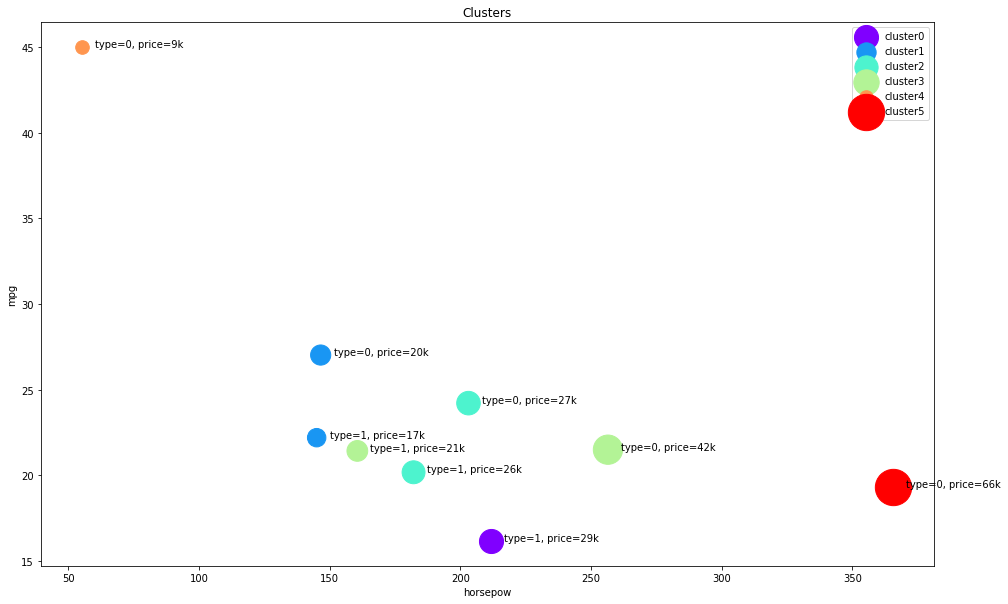

In [33]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, c=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')